# Reinforcement Q-learning simple NN as function approximation

- portfolio grid of size 10 (0 to 1)
- 1 hidden neural layers 
- Improved by Dropout 

In [1]:
# Initialization
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b,s_nom,s_pe,s_spr) 

In [3]:
data = pd.read_excel('sim_data_CER.xlsx') #Three stocks (R,X_s,X_b) Without predictors

# Initialization of the Tensorflow placeholders and the network

In [3]:
num_stocks=3

def sigmoid(x):
    return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

def sigmoidprime(x):
    return tf.multiply(sigma(x),tf.substract(tf.constant(1.0), sigma(x)))

#Initialize Neural Network and set-up the placeholders
tf.reset_default_graph()
NN_input = tf.placeholder(shape=[1,num_stocks],dtype=tf.float32)
w1 = tf.Variable(tf.random_uniform([num_stocks,100],0,1))
w2 = tf.Variable(tf.random_uniform([100,100],0,1))
w3 = tf.Variable(tf.random_uniform([100,100],0,1))
w4 = tf.Variable(tf.random_uniform([100,10],0,1))
b1 = tf.Variable(np.zeros((1,100)), dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,100)), dtype=tf.float32)
b3 = tf.Variable(np.zeros((1,100)), dtype=tf.float32)
b4 = tf.Variable(np.zeros((1,10)), dtype=tf.float32)

z1 = tf.add(tf.matmul(NN_input,w1),b1)
a1 = sigmoid(z1)

z2 = tf.add(tf.matmul(a1,w2),b2)
a2 = sigmoid(z2)

z3 = tf.add(tf.matmul(a2,w3),b3)
a3 = sigmoid(z3)

z4 = tf.add(tf.matmul(a3,w4),b4)
a4 = sigmoid(z4)

A_Max = tf.argmax(a4,1)
# Calculate loss for the NN from the Q values
Q_Next = tf.placeholder(shape=[1,10],dtype=tf.float32)
diff = tf.subtract(Q_Next,a4)
loss = tf.multiply(diff,diff)
optmzr = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
A = np.linspace(0,1,10) # portfolio weights of stocks (1-weight) is the weight in the bonds

# Training of the NN function approximation

596


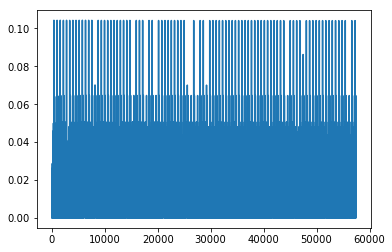

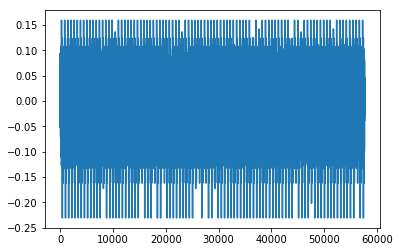

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.]
1.16625800146
Writing away results
597


KeyboardInterrupt: 

In [6]:
# initialize
init = tf.global_variables_initializer()
gamma = 0.95
epsilon = 0.1
TWlist = []
Index = []
MWeights = []
Turnover = []
chooserlist = []
RU = []
learningrateQ = 1
n = 707
periods = 20
epochs = 5     # preferred to have a low amount of epochs because otherwise the the same data is used multiple times (usually not the case in stock returns)

# data parsing
dates = data['Date']
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)

with tf.Session() as sess:
    for i in range(596,int(n-periods-1)):
        lostlist = []
        OptimalWeights = np.zeros(periods-1)
        currentK = 0
        
        
        print(i)
        rlist = []
            
        while currentK < periods - 1:
            sess.run(init) # initialize the Neural Network again
            NN_data = mdata[0:i+currentK]
            currentEpoch = 0
            for y in range(0,10):
                rlist.append(A[y]*NN_data.iloc[-1,:]['xs']+(1-A[y])*NN_data.iloc[-1,:]['xb'])
           
                    
            indexes = np.asarray(range(len(NN_data)))
#             np.random.shuffle(indexes)/
            
            while currentEpoch < epochs:
                #Training of the Q-Network for the data available (with Neural Nets) 
                for j in indexes:
                    s = NN_data.iloc[j,:].values.reshape(1,num_stocks)
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    a_int,allQ = sess.run([A_Max,a4],feed_dict={NN_input:s})
                    a = A[a_int-1]  # -1 because the output neurons arVFHe labeled 1 till 101 and it will be an index
                    if np.random.rand(1) < epsilon:
                        a = random.choice(A)

                    #Get new state and reward from environment
                    s1 = mdata.iloc[j+1,:].values.reshape(1,num_stocks)
                    r = (a*s1[0][1] + (1-a)*s1[0][2]) #reward: this is now the wealth gained from this step, but could be other rewards like utility
                    Q = sess.run(a4,feed_dict={NN_input:s1})
                    rlist.append(r)
                    #Obtain maxQ' and set our target value for chosen action.
                    Q1 = np.max(Q)
                    targetQ = allQ
                    rstd = np.std(rlist)
#                     targetQ[0,int(a*9)] = targetQ[0,int(a*9)] + learningrateQ*((r-rmean)/rstd + gamma*Q1 - targetQ[0,int(a*9)]) 
#                     targetQ[0,int(a*9)] = targetQ[0,int(a*9)] + learningrateQ*(r-rstd + gamma*Q1 - targetQ[0,int(a*9)]) 
                    targetQ[0,int(a*9)] = r-rstd + gamma*Q1
                    #Train the neural network using target and predicted Q values
                    _,W1,loss_ = sess.run([optmzr,w1,loss],feed_dict={NN_input:s,Q_Next:targetQ})
                    s =  mdata.iloc[j+1,:].values.reshape(1,num_stocks)
                    lostlist.append(sum(sum(loss_)))
                currentEpoch += 1
            

            # After training now calculate the optimal weights for the K=60 periods to come
            s = mdata.iloc[i+periods,:].values.reshape(1,num_stocks)
            a_int,allQ = sess.run([A_Max,z2],feed_dict={NN_input:s})
            aOpt = A[a_int-1]
            OptimalWeights[currentK] = aOpt
            currentK += 1
            
        # For insight purposes (Write away)
        plt.ion()
        plt.plot(lostlist)
        plt.show()
        plt.plot(rlist)
        plt.show()
        
        firstdiff = OptimalWeights[1:] - OptimalWeights[:-1]
        MWeights.append(np.mean(OptimalWeights))
        TerminalWealth = np.exp(sum(OptimalWeights*mdata[i+1:i+currentK+1]['xs'] + (1-OptimalWeights)*mdata[i+1:i+currentK+1]['xb']))
        TWlist.append(TerminalWealth)
        Index.append(i)
        Turnover.append(sum(abs(firstdiff*np.exp(mdata[i+1:i+currentK]['xs'])) + abs((1-firstdiff)*np.exp(mdata[i+1:i+currentK]['xb']))))
        RU.append((1/(1-5))*pow(TerminalWealth,(1-5)))
        print(OptimalWeights)
        print(TerminalWealth)
        
        print('Writing away results')
        df = pd.DataFrame({'index date':Index,'TW':TWlist, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU})
        df.to_excel('NN_isthisit.xlsx', sheet_name='sheet1', index=False)
print('Done!')
        